# Introduction to Graph Convolution Networks (GCN)

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, FacebookPagePage
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj, degree
from collections import Counter

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

##  Normalizing Features with Graph Convolutional Networks

In [3]:
def create_simple_graph():
    """
    Create a simple 4-node graph for demonstration.
    
    Returns:
        G: NetworkX graph object
    """
    G = nx.Graph()
    G.add_nodes_from([1, 2, 3, 4])
    G.add_edges_from([(1, 2), (1, 3), (1, 4), (3, 4)])
    return G

In [4]:
G = create_simple_graph()

In [5]:
def visualize_graph(G):
    """Visualize a NetworkX graph."""
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, 
            node_color="skyblue", font_size=12)
    plt.show()

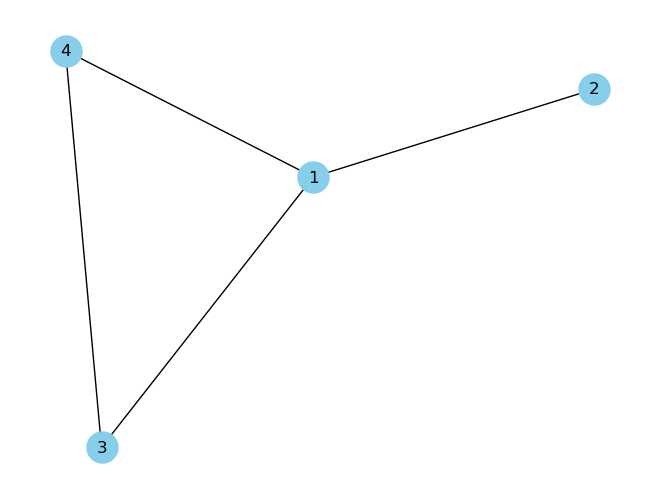

In [6]:
visualize_graph(G)

In [7]:
def compute_graph_matrices(G):
    """
    Compute adjacency and degree matrices for a graph.
    
    Args:
        G: NetworkX graph
        
    Returns:
        A: Adjacency matrix
        D: Degree matrix
    """
    # Adjacency matrix: A[i,j] = 1 if nodes i,j are connected, else 0
    A = nx.adjacency_matrix(G).toarray()
    
    # Degree matrix: diagonal matrix where D[i,i] = degree of node i
    degree_values = list(dict(G.degree()).values())
    D = np.diag(degree_values)
    
    return A, D

In [8]:
A, D =compute_graph_matrices(G)

A

array([[0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0]])

In [9]:
D

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

In [10]:
def add_self_loops(A, D):
    """
    Add self-loops to adjacency and degree matrices.
    Self-loops allow nodes to aggregate their own features.
    
    Args:
        A: Adjacency matrix
        D: Degree matrix
        
    Returns:
        A_delta: Adjacency matrix with self-loops
        D_delta: Degree matrix with self-loops
    """
    n = A.shape[0]
    I = np.identity(n)
    
    # A~ = A + I (add self-connections)
    A_delta = A + I
    
    # D~ = D + I (increment degrees)
    D_delta = D + I
    
    return A_delta, D_delta

In [11]:
A_delta, D_delta = add_self_loops(A, D)

A_delta

array([[1., 1., 1., 1.],
       [1., 1., 0., 0.],
       [1., 0., 1., 1.],
       [1., 0., 1., 1.]])

In [12]:
D_delta

array([[4., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 3., 0.],
       [0., 0., 0., 3.]])

In [13]:
def compute_normal_normalization(A, D):
    """
    Compute normal (left) normalization: D^(-1) * A
    This divides each neighbor's contribution by the node's degree.
    
    Args:
        A: Adjacency matrix
        D: Degree matrix
        
    Returns:
        Normalized adjacency matrix
    """
    D_inv = np.linalg.inv(D)
    return D_inv @ A

In [14]:
compute_normal_normalization(A, D)

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.5       , 0.        , 0.5       , 0.        ]])

In [15]:
compute_normal_normalization(A_delta, D_delta)

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

In [16]:
def compute_symmetric_normalization(A, D):
    """
    Compute symmetric normalization: D^(-1/2) * A * D^(-1/2)
    This is the standard normalization used in GCNs.
    
    The formula normalizes by both source and target node degrees,
    providing better stability during training.
    
    Args:
        A: Adjacency matrix
        D: Degree matrix
        
    Returns:
        Symmetrically normalized adjacency matrix
    """
    # Compute D^(-1/2)
    D_sqrt_inv = np.diag(1.0 / np.sqrt(np.diag(D)))
    
    # Apply symmetric normalization
    A_normalized = D_sqrt_inv @ A @ D_sqrt_inv
    
    return A_normalized

In [17]:
compute_symmetric_normalization(A, D)

array([[0.        , 0.57735027, 0.40824829, 0.40824829],
       [0.57735027, 0.        , 0.        , 0.        ],
       [0.40824829, 0.        , 0.        , 0.5       ],
       [0.40824829, 0.        , 0.5       , 0.        ]])

In [89]:
# Import necessary libraries
from torch_geometric.datasets import Planetoid
# Download the Cora dataset using Planetoid
dataset = Planetoid(root=".", name="Cora")
# Access the dataset's data
data = dataset[0]

# Print general information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


### Visualizing Node Degrees

<BarContainer object of 37 artists>

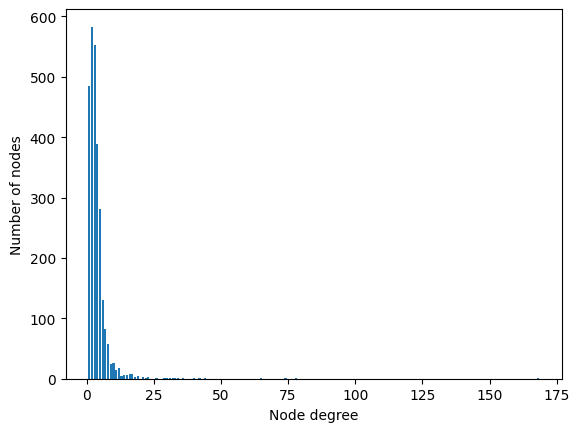

In [100]:

from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

## Implementing GCN model

In [28]:
class GCNLayer(nn.Module):
    """
    Custom Graph Convolutional Layer.
    
    Implements the operation: H' = σ(D^(-1/2) * A * D^(-1/2) * H * W)
    where:
    - A: Adjacency matrix (with self-loops)
    - D: Degree matrix
    - H: Node feature matrix
    - W: Learnable weight matrix
    - σ: Activation function
    """
    
    def __init__(self, in_features, out_features):
        """
        Initialize the GCN layer.
        
        Args:
            in_features: Number of input features per node
            out_features: Number of output features per node
        """
        super(GCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize learnable weight matrix
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)  # Xavier initialization
    
    def forward(self, x, adjacency):
        """
        Forward pass of the GCN layer.
        
        Args:
            x: Node feature matrix [num_nodes, in_features]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
            
        Returns:
            output: Transformed node features [num_nodes, out_features]
        """
        # Step 1: Compute symmetric normalization
        degree = torch.sum(adjacency, dim=1)
        degree_sqrt_inv = 1.0 / torch.sqrt(degree)
        D_sqrt_inv = torch.diag(degree_sqrt_inv)
        
        # Normalize adjacency: A_norm = D^(-1/2) * A * D^(-1/2)
        adjacency_norm = torch.mm(torch.mm(D_sqrt_inv, adjacency), D_sqrt_inv)
        
        # Step 2: Transform features: H * W
        support = torch.mm(x, self.weight)
        
        # Step 3: Aggregate from neighbors: A_norm * (H * W)
        output = torch.mm(adjacency_norm, support)
        
        return output

class GCN(nn.Module):
    """
    Graph Convolutional Network for node classification.
    
    Architecture: Input -> GCN Layer -> ReLU -> GCN Layer -> LogSoftmax
    """
    
    def __init__(self, num_features, hidden_dim, num_classes):
        """
        Initialize the GCN model.
        
        Args:
            num_features: Number of input features per node
            hidden_dim: Number of hidden units
            num_classes: Number of output classes
        """
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(num_features, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, num_classes)
    
    def forward(self, x, adjacency):
        """
        Forward pass through the network.
        
        Args:
            x: Node features [num_nodes, num_features]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
            
        Returns:
            Log probabilities for each class [num_nodes, num_classes]
        """
        # First GCN layer with ReLU activation
        h = self.gcn1(x, adjacency)
        h = torch.relu(h)
        
        # Second GCN layer
        h = self.gcn2(h, adjacency)
        
        # Apply log softmax for classification
        return F.log_softmax(h, dim=1)
    
    def accuracy(self, y_pred, y_true):
        """Calculate classification accuracy."""
        return torch.sum(y_pred == y_true).float() / len(y_true)
    
    def fit(self, data, epochs, adjacency):
        """
        Train the GCN model.
        
        Args:
            data: PyTorch Geometric data object
            epochs: Number of training epochs
            adjacency: Adjacency matrix (with self-loops)
            
        Returns:
            Trained model and training history
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        # Storage for training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        
        self.train()
        
        for epoch in range(epochs + 1):
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = self(data.x, adjacency)
            
            # Compute loss and accuracy on training set
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = self.accuracy(out[data.train_mask].argmax(dim=1), 
                               data.y[data.train_mask])
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Log progress every 20 epochs
            if epoch % 20 == 0:
                # Compute validation metrics
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(out[data.val_mask].argmax(dim=1), 
                                       data.y[data.val_mask])
                
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | '
                      f'Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
                
                # Store metrics
                history['train_loss'].append(loss.item())
                history['val_loss'].append(val_loss.item())
                history['train_acc'].append(acc.item())
                history['val_acc'].append(val_acc.item())
        
        return history
    
    @torch.no_grad()
    def test(self, data, adjacency):
        """
        Evaluate model on test set.
        
        Args:
            data: PyTorch Geometric data object
            adjacency: Adjacency matrix
            
        Returns:
            Test accuracy
        """
        self.eval()
        out = self(data.x, adjacency)
        acc = self.accuracy(out.argmax(dim=1)[data.test_mask], 
                           data.y[data.test_mask])
        return acc

# Built-in GCN Implementation

In [29]:
class GCN_Builtin(nn.Module):
    """
    GCN using PyTorch Geometric's built-in GCNConv layer.
    More efficient and optimized than manual implementation.
    """
    
    def __init__(self, dim_in, dim_h, dim_out):
        """
        Initialize the GCN model.
        
        Args:
            dim_in: Input feature dimension
            dim_h: Hidden dimension
            dim_out: Output dimension (number of classes)
        """
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        """
        Forward pass using edge index format (more efficient).
        
        Args:
            x: Node features [num_nodes, dim_in]
            edge_index: Graph connectivity [2, num_edges]
            
        Returns:
            Log probabilities [num_nodes, dim_out]
        """
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        """Train the model."""
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        
        self.train()
        
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), 
                          data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), 
                                  data.y[data.val_mask])
                
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | '
                      f'Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
                
                history['train_loss'].append(loss.item())
                history['val_loss'].append(val_loss.item())
                history['train_acc'].append(acc.item())
                history['val_acc'].append(val_acc.item())
        
        return history
    
    @torch.no_grad()
    def test(self, data):
        """Evaluate on test set."""
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

## Deep GCN Architecture

In [30]:
class DeepGCN(nn.Module):
    """
    Deeper GCN with 4 hidden layers for increased representation capacity.
    
    Architecture:
    Input -> GCN1 -> ReLU -> Dropout -> GCN2 -> ReLU -> Dropout ->
    GCN3 -> ReLU -> Dropout -> GCN4 -> ReLU -> Dropout -> GCN5 -> Output
    """
    
    def __init__(self, dim_in, dim_h, dim_out, dropout=0.5):
        """
        Initialize Deep GCN.
        
        Args:
            dim_in: Input feature dimension
            dim_h: Hidden dimension
            dim_out: Output dimension
            dropout: Dropout rate (default 0.5)
        """
        super().__init__()
        
        # Define 5 GCN layers (4 hidden + 1 output)
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_h)
        self.gcn3 = GCNConv(dim_h, dim_h)
        self.gcn4 = GCNConv(dim_h, dim_h)
        self.gcn5 = GCNConv(dim_h, dim_out)
        
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        """
        Forward pass through deep architecture.
        
        Args:
            x: Node features
            edge_index: Graph connectivity
            
        Returns:
            Log probabilities for classification
        """
        # Layer 1
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Layer 2
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Layer 3
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Layer 4
        h = self.gcn4(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Output layer
        h = self.gcn5(h, edge_index)
        
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        """Train the deep model."""
        criterion = nn.CrossEntropyLoss()
        # Use lower learning rate for deeper networks
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
        
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        
        self.train()
        
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), 
                          data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), 
                                  data.y[data.val_mask])
                
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | '
                      f'Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
                
                history['train_loss'].append(loss.item())
                history['val_loss'].append(val_loss.item())
                history['train_acc'].append(acc.item())
                history['val_acc'].append(val_acc.item())
        
        return history
    
    @torch.no_grad()
    def test(self, data):
        """Evaluate on test set."""
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

## UTILITY FUNCTIONS

In [31]:
def accuracy(y_pred, y_true):
    """Calculate accuracy of predictions."""
    return torch.sum(y_pred == y_true).float() / len(y_true)

def visualize_training(history, title="Training History"):
    """
    Visualize training and validation metrics.
    
    Args:
        history: Dictionary with train/val loss and accuracy
        title: Plot title
    """
    epochs = range(0, len(history['train_loss']) * 20, 20)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'o-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'o-', label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def prepare_adjacency_matrix(data):
    """
    Convert edge index to dense adjacency matrix with self-loops.
    
    Args:
        data: PyTorch Geometric data object
        
    Returns:
        Dense adjacency matrix with self-loops
    """
    adjacency = to_dense_adj(data.edge_index)[0]
    adjacency += torch.eye(len(adjacency))
    return adjacency

def visualize_node_degrees(data):
    """Visualize the distribution of node degrees."""
    degrees = degree(data.edge_index[0]).numpy()
    numbers = Counter(degrees)
    
    plt.figure(figsize=(10, 5))
    plt.bar(numbers.keys(), numbers.values(), color='steelblue', alpha=0.7)
    plt.xlabel('Node Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Node Degree Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

## Usage

In [32]:
def run_cora_example():
    """Example: Train GCN on Cora dataset."""
    print("Training builtin GCN on Cora Dataset")
    
    # Load dataset
    dataset = Planetoid(root=".", name="Cora")
    data = dataset[0]
    
    print(f"Dataset: {dataset}")
    print(f"Number of nodes: {data.x.shape[0]}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print()
    
    # Train built-in GCN
    model = GCN_Builtin(dataset.num_features, 16, dataset.num_classes)
    history = model.fit(data, epochs=100)
    acc = model.test(data)
    
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    
    # Visualize results
    visualize_training(history, "GCN on Cora")
    
    return model, history

Training builtin GCN on Cora Dataset
Dataset: Cora()
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch   0 | Train Loss: 1.955 | Train Acc: 13.57% | Val Loss: 1.96 | Val Acc: 9.60%
Epoch  20 | Train Loss: 0.096 | Train Acc: 100.00% | Val Loss: 0.78 | Val Acc: 77.20%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.60%
Epoch  60 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 78.00%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 78.20%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.60%

Test Accuracy: 80.70%


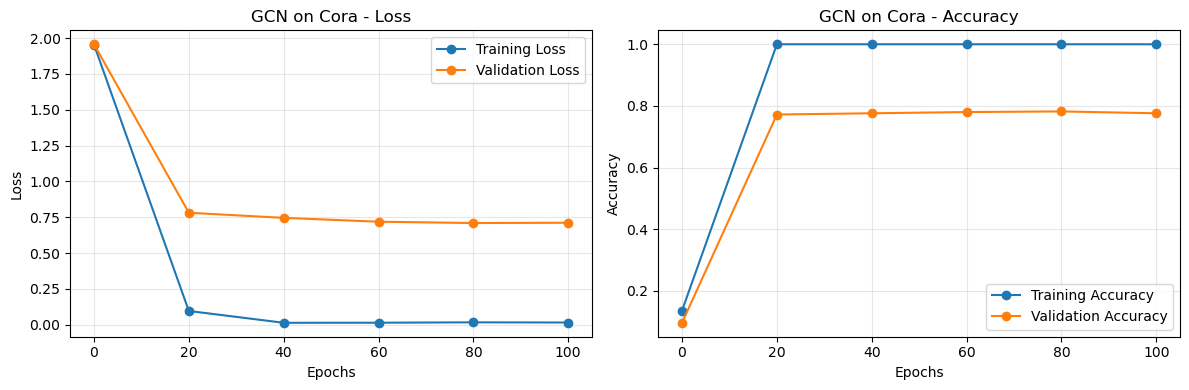

(GCN_Builtin(
   (gcn1): GCNConv(1433, 16)
   (gcn2): GCNConv(16, 7)
 ),
 {'train_loss': [1.95480215549469,
   0.09625592827796936,
   0.01372709684073925,
   0.014329527504742146,
   0.016882598400115967,
   0.015673305839300156],
  'train_acc': [0.13571429252624512, 1.0, 1.0, 1.0, 1.0, 1.0],
  'val_loss': [1.9569566249847412,
   0.7814348936080933,
   0.745853841304779,
   0.7188871502876282,
   0.7097926735877991,
   0.7116755843162537],
  'val_acc': [0.09600000083446503,
   0.7720000147819519,
   0.7760000228881836,
   0.7799999713897705,
   0.7820000052452087,
   0.7760000228881836]})

In [33]:
run_cora_example()

In [39]:
def run_cora_example():
    """Example: Train custom GCN on Cora dataset."""
    print("Training custom GCN on Cora Dataset")
    
    # Load dataset
    dataset = Planetoid(root=".", name="Cora")
    data = dataset[0]
    
    print(f"Dataset: {dataset}")
    print(f"Number of nodes: {data.x.shape[0]}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print()
    
    # Train built-in GCN
    model = GCN(dataset.num_features, 16, dataset.num_classes)
    history = model.fit(data, epochs=100, adjacency=prepare_adjacency_matrix(data))
    acc = model.test(data, adjacency=prepare_adjacency_matrix(data))
    
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    
    # Visualize results
    visualize_training(history, "GCN on Cora")
    
    return model, history

Training custom GCN on Cora Dataset
Dataset: Cora()
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch   0 | Train Loss: 1.947 | Train Acc: 15.71% | Val Loss: 1.97 | Val Acc: 6.40%
Epoch  20 | Train Loss: 0.121 | Train Acc: 100.00% | Val Loss: 0.82 | Val Acc: 76.60%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.81 | Val Acc: 75.80%
Epoch  60 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.78 | Val Acc: 76.60%
Epoch  80 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 76.40%
Epoch 100 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.40%

Test Accuracy: 79.60%


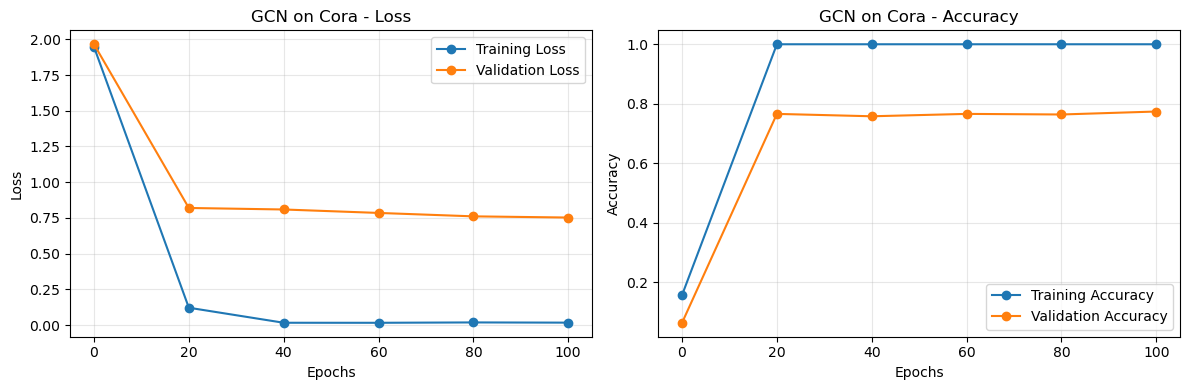

(GCN(
   (gcn1): GCNLayer()
   (gcn2): GCNLayer()
 ),
 {'train_loss': [1.9465466737747192,
   0.12122751027345657,
   0.016001636162400246,
   0.01572893187403679,
   0.018304571509361267,
   0.016815338283777237],
  'train_acc': [0.15714286267757416, 1.0, 1.0, 1.0, 1.0, 1.0],
  'val_loss': [1.965281367301941,
   0.8194229006767273,
   0.8088289499282837,
   0.7846922278404236,
   0.7607360482215881,
   0.7524529099464417],
  'val_acc': [0.06400000303983688,
   0.765999972820282,
   0.7580000162124634,
   0.765999972820282,
   0.7639999985694885,
   0.7739999890327454]})

In [40]:
run_cora_example()

In [41]:
def run_cora_example():
    """Example: Train deeper GCN on Cora dataset."""
    print("Training deeper GCN on Cora Dataset")
    
    # Load dataset
    dataset = Planetoid(root=".", name="Cora")
    data = dataset[0]
    
    print(f"Dataset: {dataset}")
    print(f"Number of nodes: {data.x.shape[0]}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    print()
    
    # Train built-in GCN
    model = DeepGCN(dataset.num_features, 16, dataset.num_classes)
    history = model.fit(data, epochs=100)
    acc = model.test(data)
    
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    
    # Visualize results
    visualize_training(history, "GCN on Cora")
    
    return model, history

Training deeper GCN on Cora Dataset
Dataset: Cora()
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch   0 | Train Loss: 1.946 | Train Acc: 17.86% | Val Loss: 1.95 | Val Acc: 12.00%
Epoch  20 | Train Loss: 1.391 | Train Acc: 41.43% | Val Loss: 1.59 | Val Acc: 36.00%
Epoch  40 | Train Loss: 0.680 | Train Acc: 77.86% | Val Loss: 1.17 | Val Acc: 60.40%
Epoch  60 | Train Loss: 0.424 | Train Acc: 85.00% | Val Loss: 1.33 | Val Acc: 66.20%
Epoch  80 | Train Loss: 0.406 | Train Acc: 85.71% | Val Loss: 1.25 | Val Acc: 68.20%
Epoch 100 | Train Loss: 0.161 | Train Acc: 96.43% | Val Loss: 1.57 | Val Acc: 66.00%

Test Accuracy: 73.50%


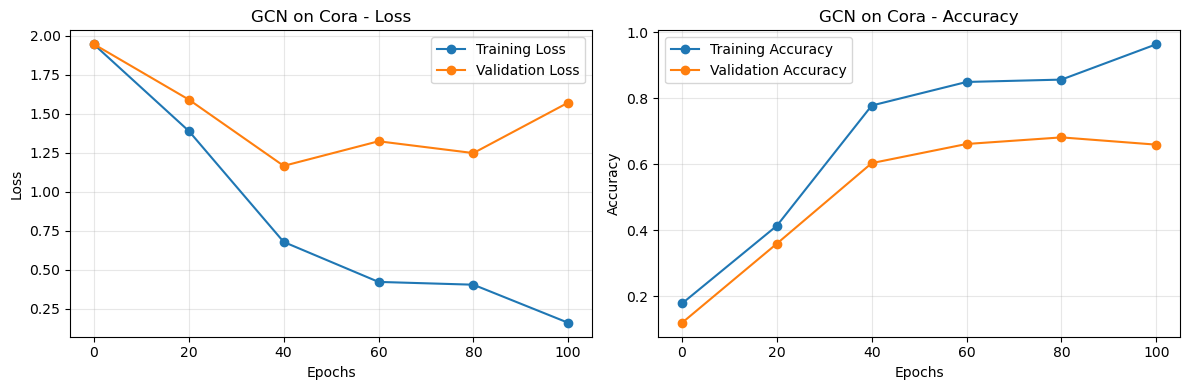

(DeepGCN(
   (gcn1): GCNConv(1433, 16)
   (gcn2): GCNConv(16, 16)
   (gcn3): GCNConv(16, 16)
   (gcn4): GCNConv(16, 16)
   (gcn5): GCNConv(16, 7)
 ),
 {'train_loss': [1.945766806602478,
   1.3908807039260864,
   0.679743230342865,
   0.42356154322624207,
   0.40567532181739807,
   0.16146084666252136],
  'train_acc': [0.1785714328289032,
   0.41428571939468384,
   0.7785714268684387,
   0.8500000238418579,
   0.8571428656578064,
   0.9642857313156128],
  'val_loss': [1.9469610452651978,
   1.592154860496521,
   1.1674026250839233,
   1.3251293897628784,
   1.2493940591812134,
   1.573098063468933],
  'val_acc': [0.11999999731779099,
   0.36000001430511475,
   0.6039999723434448,
   0.6620000004768372,
   0.6819999814033508,
   0.6600000262260437]})

In [42]:
run_cora_example()